In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
torch.cuda.set_device(0)

In [4]:
PATH = "intel/"

In [5]:
train_csv = f'{PATH}train.csv'
n = len(list(open(train_csv))) - 1 # header is not counted (-1)
val_idxs = get_cv_idxs(n) # random 20% data for validation set

In [6]:
!ls

fastai	intel  intel.ipynb  intel1.ipynb  s.csv  t.py


In [7]:
!ls {PATH}

models	sample.csv  test  test.csv  tmp  train	train.csv  train.zip


In [8]:
train = pd.read_csv(train_csv)

In [9]:
train.head()

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4


In [10]:
train.pivot_table(index='label',aggfunc=len).sort_values(by='image_name')

,image_name
label,
0,2628
1,2745
4,2784
5,2883
2,2957
3,3037


In [11]:
arch = resnet34
#arch = resnext101
bs = 64

def get_data(sz, bs): # sz: image size, bs: batch size
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}train.csv', test_name='test',
                                       val_idxs=[0], tfms=tfms, bs=bs)
    
    return data 

In [12]:
import os
import shutil

In [13]:
test = pd.read_csv(f'{PATH}test.csv');test.head()

,image_name
0,3.jpg
1,5.jpg
2,6.jpg
3,11.jpg
4,14.jpg


In [14]:
'''
for r in test.iterrows():
    shutil.copy2((f'{PATH}train/' +r[1].values[0]), (f'{PATH}test/' +r[1].values[0]))
    #print (f'{PATH}train/' +r[1].values[0])
    #print(type(r[1].values[0]))
'''

"\nfor r in test.iterrows():\n    shutil.copy2((f'{PATH}train/' +r[1].values[0]), (f'{PATH}test/' +r[1].values[0]))\n    #print (f'{PATH}train/' +r[1].values[0])\n    #print(type(r[1].values[0]))\n"

In [15]:
sz = 100
data = get_data(sz, bs)

In [16]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

 83%|████████▎ | 221/267 [00:03<00:00, 59.53it/s, loss=1.37] 


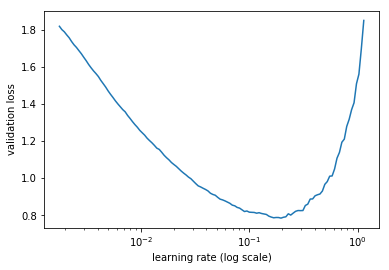

In [17]:
learn.lr_find()
learn.sched.plot(100)

In [18]:
lr =8e-2
learn.fit(lr, 10)

epoch      trn_loss   val_loss   accuracy                    
    0      0.457467   0.241464   1.0       
    1      0.371568   0.720745   1.0                         
    2      0.308038   0.527178   1.0                         
    3      0.299045   0.348353   1.0                         
    4      0.290519   0.441548   1.0                         
    5      0.275544   0.700616   1.0                         
    6      0.27094    0.62167    1.0                         
    7      0.291084   0.277607   1.0                         
    8      0.271876   0.484772   1.0                         
    9      0.258556   0.099193   1.0                         



[array([0.09919]), 1.0]

In [19]:
lrs = np.array([lr/8,lr/2,lr])
learn.unfreeze()
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.298079   0.411199   1.0       
    1      0.287929   0.256555   1.0                         
    2      0.267667   0.309349   1.0                         



[array([0.30935]), 1.0]

In [20]:
sz=150
learn.set_data(get_data(sz,bs))
learn.freeze()
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.264641   0.335151   1.0       
    1      0.253506   0.301091   1.0                         
    2      0.227851   0.210845   1.0                         



[array([0.21084]), 1.0]

In [21]:
learn.unfreeze()
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.290355   0.33793    1.0       
    1      0.275085   4.280131   0.0                         
    2      0.193974   0.089761   1.0                         



[array([0.08976]), 1.0]

In [22]:
sz=200
learn.set_data(get_data(sz,bs))
learn.freeze()
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.180609   0.178459   1.0       
    1      0.190406   0.078421   1.0                         
    2      0.162267   0.077021   1.0                         



[array([0.07702]), 1.0]

In [38]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.165711   0.150288   1.0       
    1      0.200272   0.130915   1.0                         
    2      0.131086   0.156715   1.0                         
    3      0.172976   0.449126   1.0                         
    4      0.144101   0.022469   1.0                         
    5      0.101792   0.092335   1.0                          
    6      0.084492   0.046531   1.0                          



[array([0.04653]), 1.0]

In [39]:
fn = data.test_ds.fnames

In [40]:
(np.array(fn)).shape

(7301,)

In [41]:
log_preds, y = learn.TTA(is_test=True) # use test dataset rather than validation dataset
probs = np.mean(np.exp(log_preds),0)

In [42]:
probs.shape

(7301, 6)

In [43]:
p = np.argmax(probs,axis=1);p.shape

(7301,)

In [44]:
df = pd.DataFrame(p,columns=['label'])

In [45]:
df.insert(0, 'image_name', [f[5:] for f in data.test_ds.fnames])

In [46]:
df['ord'] = fn
df['ord'] = df['ord'].str[5:-4].astype(int)
df = df.sort_values(by='ord')
#df.reset_index();df.head()

#sample = df[['image_name','label']];sample.head()

In [47]:
sample = df.copy()

In [48]:
sample.head()

,image_name,label,ord
5729,3.jpg,5,3
2123,5.jpg,0,5
525,6.jpg,4,6
5376,11.jpg,2,11
2851,14.jpg,5,14


In [49]:
sub =sample.reset_index()

In [50]:
sub = sub[['image_name','label']];sub.head()

,image_name,label
0,3.jpg,5
1,5.jpg,0
2,6.jpg,4
3,11.jpg,2
4,14.jpg,5


In [51]:
sub.to_csv('s.csv', encoding='utf-8', index=False)

In [52]:
learn.save('200_all_2')

In [132]:
#learn.load('200_all')